<a href="https://colab.research.google.com/github/abhinav-exp/Forecasting-CryptoCurrency-Prices/blob/master/TFLANN_with_JAYA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
GitHubDataLink = 'https://raw.githubusercontent.com/abhinav-exp/Forecasting-CryptoCurrency-Prices/master/Datasets/'
InputFileLink = GitHubDataLink + 'DataBTC2017.csv'
data1 = pd.read_csv(InputFileLink, header=0, index_col=0)
print(data1)

            CBBTCUSD
DATE                
2017-06-18   2515.25
2017-06-19   2596.98
2017-06-20   2725.08
2017-06-21   2643.35
2017-06-22   2679.99
...              ...
2019-08-03  10820.75
2019-08-04  10997.82
2019-08-05  11775.14
2019-08-06  11440.08
2019-08-07  12014.41

[781 rows x 1 columns]


In [4]:
data1min = data1.min()
data1max = data1.max()

normalize = lambda x: (x - data1min + 1)/(data1max - data1min + 2)
data2 = normalize(data1)
print(data2)

            CBBTCUSD
DATE                
2017-06-18  0.034073
2017-06-19  0.038680
2017-06-20  0.045901
2017-06-21  0.041294
2017-06-22  0.043360
...              ...
2019-08-03  0.502247
2019-08-04  0.512228
2019-08-05  0.556045
2019-08-06  0.537158
2019-08-07  0.569532

[781 rows x 1 columns]


In [5]:
def split_sequence(sequence, n_steps):
  X= list()
  for i in range(len(sequence) - n_steps):
    end_ix = i + n_steps
    seq_x= sequence.values[i:end_ix, 0]
    X.append(seq_x) 
  return pd.DataFrame(X)

data3 = split_sequence(data2, 10)
print(data3.shape)
print(data3)

(771, 10)
            0         1         2         3         4         5         6  \
0    0.034073  0.038680  0.045901  0.041294  0.043360  0.043967  0.037432   
1    0.038680  0.045901  0.041294  0.043360  0.043967  0.037432  0.033530   
2    0.045901  0.041294  0.043360  0.043967  0.037432  0.033530  0.028023   
3    0.041294  0.043360  0.043967  0.037432  0.033530  0.028023  0.037484   
4    0.043360  0.043967  0.037432  0.033530  0.028023  0.037484  0.036208   
..        ...       ...       ...       ...       ...       ...       ...   
766  0.441959  0.449255  0.447073  0.426045  0.430599  0.427984  0.432307   
767  0.449255  0.447073  0.426045  0.430599  0.427984  0.432307  0.461562   
768  0.447073  0.426045  0.430599  0.427984  0.432307  0.461562  0.479501   
769  0.426045  0.430599  0.427984  0.432307  0.461562  0.479501  0.486030   
770  0.430599  0.427984  0.432307  0.461562  0.479501  0.486030  0.502247   

            7         8         9  
0    0.033530  0.028023  0.03

In [6]:
train_x = data3.iloc[:int(0.85*len(data2)), :9]
train_y = data3.iloc[:int(0.85*len(data2)), 9:10]
test_x = data3.iloc[int(0.85*len(data2)):, :9]
test_y = data3.iloc[int(0.85*len(data2)):, 9:10]
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(663, 9)
(663, 1)
(108, 9)
(108, 1)


In [70]:
class TFLANN():
  def __init__(self, W):
    self.weight_matrix = W
  
  def func_x(self, x):
    const_x = np.ones((len(x), 1))
    orginal_x = x
    sinned_x = np.sin(np.pi*x)
    cossed_x = np.cos(np.pi*x)
    # print(const_x)
    # print(x.shape)
    # print(const_x.shape)
    functioned_x = np.hstack((x, sinned_x, cossed_x, const_x))
    return functioned_x

  def forward_propagation(self, x):
    funced_x = self.func_x(x)
    return (np.tanh(np.dot(funced_x, self.weight_matrix)) + 1)/2

In [77]:
find_mse = lambda x , y: np.mean((x - y) ** 2)

class JAYATFLANN():
  def __init__(self, p_size):
    self.p_size = p_size
    self.data = []

    for i in range(p_size):
      d = {}
      d['W'] = np.random.random((9*3 + 1, 1))
      model = TFLANN(d['W'])
      d['mse'] = find_mse(model.forward_propagation(train_x), train_y)
      self.data.append(d)

    print(sum([v['mse'][9] for v in self.data]))
    print([v['mse'][9] for v in self.data])

    self.update_best_and_worst()

  def update_best_and_worst(self):
    self.best = 0
    self.worst = 0
    for i in range(self.p_size):
      if self.data[self.best]['mse'][9] > self.data[i]['mse'][9]:
        self.best = i
      if self.data[self.worst]['mse'][9] < self.data[i]['mse'][9]:
        self.worst = i

  def next_gen(self):
    for i in range(self.p_size):
      t =  self.data[i]['W']
      t += np.random.random((9*3 + 1, 1)) * (self.data[self.best]['W'] - self.data[i]['W'])
      t -= np.random.random((9*3 + 1, 1)) * (self.data[self.worst]['W'] - self.data[i]['W'])
      model = TFLANN(t)
      mse = find_mse(model.forward_propagation(train_x), train_y)
      if mse[9] < self.data[i]['mse'][9]:
        self.data[i] = {'W': t, 'mse':mse}

    self.update_best_and_worst()

  def optimise(self, gen):
    for i in range(gen):
      self.next_gen()
      print(sum([v['mse'][9] for v in self.data]))

In [78]:
optimiser = JAYATFLANN(50)
optimiser.optimise(100)
model = TFLANN(optimiser.data[optimiser.best]['W'])
preds = model.forward_propagation(test_x)
print(preds.shape)

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


28.635683955716317
[0.5723132158159119, 0.5726000068510442, 0.5724476731418173, 0.5726836449876642, 0.5765712932242646, 0.5726472957269645, 0.5726948913916152, 0.5724180603269621, 0.5722988684855158, 0.5723309418143149, 0.5733605830060867, 0.5724416493767689, 0.5724466170556893, 0.5725279821181043, 0.5726642252940995, 0.5722563795866122, 0.5725763757577781, 0.5726696132738704, 0.572616464579294, 0.5726737051655225, 0.5725300863229117, 0.5722675536783001, 0.5723620388259771, 0.5724662625305068, 0.5726879041007745, 0.5726908328698207, 0.5723216219379348, 0.5726372459429413, 0.572661473555319, 0.5721017201945382, 0.572543491151585, 0.5723959903885489, 0.5726031795168881, 0.5726562520056504, 0.5750237053411504, 0.5726788974399298, 0.5726568237695951, 0.5726733154484015, 0.5725743056736649, 0.572625877415963, 0.5725764798140007, 0.5726270768857564, 0.5726712595883072, 0.573868033364586, 0.5726849642090859, 0.5726860949941359, 0.5726944682859614, 0.5726540017192033, 0.5722157005419808, 0.572

In [79]:
preds[:, 0]

array([0.42350234, 0.3985213 , 0.41890429, 0.44478734, 0.42837606,
       0.37567019, 0.40948216, 0.44142409, 0.35987823, 0.29711702,
       0.35798917, 0.35284747, 0.36244731, 0.42920731, 0.49313354,
       0.47593266, 0.50496401, 0.58774533, 0.59033495, 0.58996818,
       0.61771197, 0.76259719, 0.79018933, 0.87915216, 0.93340442,
       0.96595012, 0.92309501, 0.9456278 , 0.89909748, 0.94279059,
       0.90587071, 0.83650997, 0.851392  , 0.93021701, 0.90280524,
       0.92135294, 0.94189337, 0.95778606, 0.9520276 , 0.95928309,
       0.96171128, 0.95109934, 0.95060132, 0.94827105, 0.88044932,
       0.8777569 , 0.87423863, 0.88508358, 0.835813  , 0.84675635,
       0.83505422, 0.8846996 , 0.91193865, 0.91206142, 0.91330904,
       0.95846333, 0.95442684, 0.97098672, 0.97929879, 0.97883527,
       0.97902759, 0.98366304, 0.99084417, 0.99270448, 0.99508484,
       0.99615138, 0.99825781, 0.99942131, 0.99684679, 0.9986247 ,
       0.99633973, 0.98289738, 0.98234659, 0.97472714, 0.99007

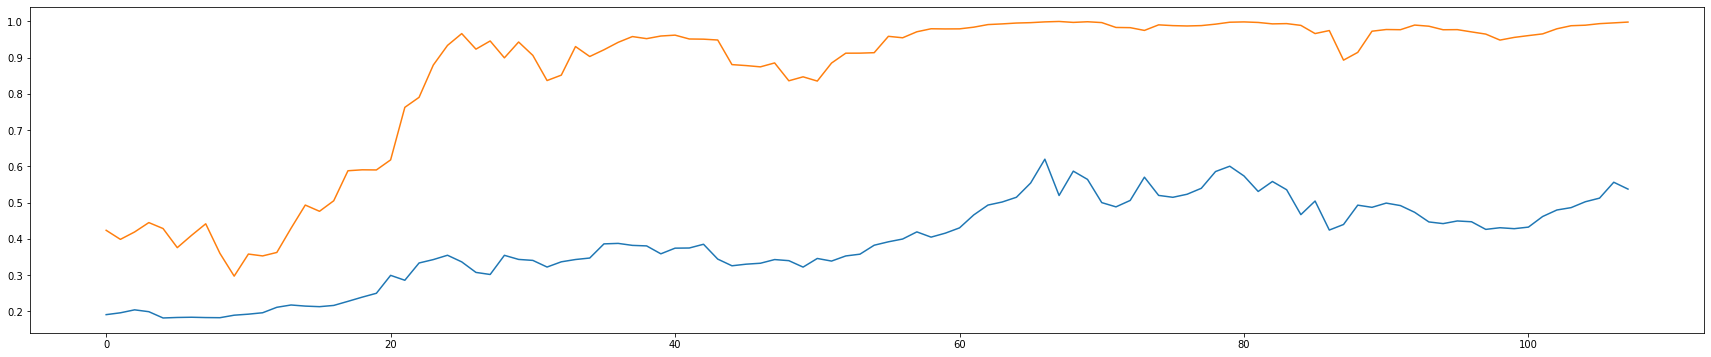

In [80]:
plt.figure(figsize=(30, 6))
plt.plot(test_y.reset_index()[9])
plt.plot(preds)
plt.show()